In [1]:
#import sys
#sys.path.append('/Users/atw/anaconda3/pkgs/uproot-5.3.7-ha770c72_0.conda')
#sys.path.append('/Users/atw/anaconda3/pkgs/uproot-base-5.3.7-pyhd8ed1ab_0.conda')
import os
import math
import pandas as pd
import numpy as np
import uproot
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [2]:
Files= ["l1calo_hist_ZMUMU_extended.root","l1calo_hist_ZMUMU_extended_new.root","l1calo_hist_EGZ_extended.root","l1calo_hist_EGZ_extended_new.root"] # "extended" includes isolation vars and extended_new trigger decision

In [3]:
def VariableMaker(inputs):
    ''' 
    Takes the list of supercells corresponding to an eFEX 
    processing window and constructs additional variables 
    using them. 
    Returns list of sums calculated from them

    inputs = copy of the SuperCells_ET vector for an RoI
    '''

    '''
    The SuperCell_ET variable in the root file contains a vector of 99 supercells for each RoI
    To understand its contents, consider that the algorithm window in the eFEX is based on 3x3 
    towers, each tower containing 11 supercells:
    
       1 Presampler, 4 Layer 1, 4 Layer 2, 1 Layer 3, 1 Hadronic
       
    Think of the towers being numbered as below:

       -------------
       | 6 | 7 | 8 |
       -------------
       | 3 | 4 | 5 |
       -------------
       | 0 | 1 | 2 |
       -------------

    where eta increases from left to right and phi increases from bottom to top.
    Within each tower the cells are ordered as above (PS, EM1, EM2, EM3, Had),
    and where there are 4 cells in a layer they are ordered in increasing eta.
    Therefore when we think of the numbering of these 99 cells in the SuperCell_ET
    array:
       Cells  0-10 are PS, 4*EM1, 4*EM2, EM3, Had for Tower 0
       Cells 11-21 are PS, 4*EM1, 4*EM2, EM3, Had for Tower 1
               ...
       Cells 88-98 are PS, 4*EM1, 4*EM2, EM3, Had for Tower 8
       
    '''

    # Mapping cells in "inputs" to tower, layer, cell: 
    '''
      Each of the vectors below contains indices of cells in a given layer in the "inputs" array.

        map0[n] = index of presampler cell in tower n
        map3[n], mapH[n] = indices for EM3 and hadronic cells in tower n
        
      For layer 1 and 2, where there are 4 cells/tower, the first 4 in each map = tower 0, 
      next 4 = tower 1, etc. So if you want the position of supercell X (0-3) from tower n (0-8)
      for these layers it is:
        map1[(n*11)+X] or map1[(n*11)+X]
    '''
    
    map0 = [0,11,22,3,44,55,66,77,88]    
    map1 = [1,2,3,4,12,13,14,15,23,24,25,26,34,35,36,37,45,46,47,48,56,57,58,59,67,68,69,70,78,79,80,81,89,90,91,92]
    map2 = [5,6,7,8,16,17,18,19,27,28,29,30,38,39,40,41,49,50,51,52,60,61,62,63,71,72,73,74,82,83,84,85,93,94,95,96]    
    map3 = [9,20,31,42,53,64,75,86,97]    
    mapH = [10,21,32,43,54,65,76,87,98]    
    
    # Need to find seed cell in central tower.
    seedCell = 0
    seeds = np.array([])
    seedETs = np.array([])

    for sc in range(5,9):
        cell = 44 + sc
        scM = sc - 1
        cellM = 44+scM if scM >= 5 else 41 # cell 8 of tower 3 (33+8)
        scP = sc + 1
        cellP = 44+scP if scP <= 8 else 60 # cell 5 of tower 5 (55+5)
        if inputs[cell] >= inputs[cellM] and inputs[cell] > inputs[cellP]:
            seeds = np.append(seeds,sc)
            seedETs = np.append(seedETs,inputs[cell])

    if seeds.size == 0 or seeds.size > 2:
        print("Error: invalid number of seeds found!")
        return variables
    elif seeds.size == 1:
        seedCell = int(seeds[0])
    else:
        if seedETs[0] > seedETs[1]:
            seedCell = int(seeds[0])
        else:
            seedCell = int(seeds[1])
            
    # Now apply UnD logic
    up =   int(77 + seedCell)
    down = int(11 + seedCell)
    UnD = 1 if inputs[up] >= inputs[down] else 0

    # Have the seed, now can form some sums

    # Sanity check: build the trigger cluster

    # Presampler & layer 3: cluster = central tower supercell plus tower above/below in phi
    clus0 = inputs[44] + (inputs[77] if UnD > 0 else inputs[11])
    clus3 = inputs[53] + (inputs[86] if UnD > 0 else inputs[20])

    '''
    Layers 1 and 2: cluster = seed supercell + 2 eta neighbours, 
    plus same group from tower above/below in phi.

    If the seed cell is cell 5 (left-hand edge of central tower) then neighbour to
    left will not be cell 4 in that tower but cell 8 (right-hand edge) in the previous tower.

    Similarly if seed is cell 8 (right-hand edge) then neighbour will be cell 5 in next tower.
    '''
    clus1 = 0
    clus2 = 0
    for off in range(-1,2):
        cell = seedCell + off # cell in layer 2
        towerC = 44 # Start of central tower (tower 4 of 8)
        # 
        if cell < 5: # to the left of central tower
            towerC = 33 # previous tower
            cell   = 8  # right-hand cell in that tower
        elif cell > 8: # to the right of central tower
            towerC = 55 # next tower
            cell   = 5  # left-hand cell of next tower
        # Neighbouring tower in phi (above or below)
        towerN = towerC+33 if UnD > 0 else towerC - 33
        clus1 += inputs[towerC+cell-4] + inputs[towerN+cell-4] # cells from layer 1
        clus2 += inputs[towerC+cell]   + inputs[towerN+cell]   # cells from layer 2 
    
    return clus0, clus1, clus2, clus3

In [4]:
DFs = []

for i in range (0,len(Files)):
  File = uproot.open(Files[i])
  Tree = File["tree_DMC"]
  DFs.append(Tree.arrays(library="pd"))
  print (DFs[i].shape)

(141741, 22)
(141741, 17)
(89169, 22)
(89169, 17)


In [5]:
#DFs[0].head()

In [6]:
#DFs[1].head()

In [7]:
DFs[0].info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141741 entries, 0 to 141740
Data columns (total 22 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   TOB_ET               141741 non-null  float32
 1   TOB_eta              141741 non-null  float32
 2   TOB_ieta             141741 non-null  int32  
 3   TOB_ietabin          141741 non-null  uint32 
 4   TOB_phi              141741 non-null  float32
 5   offline_ele_pt       141741 non-null  float32
 6   offline_ele_eta      141741 non-null  float32
 7   offline_ele_eta_cal  141741 non-null  float32
 8   offline_ele_phi      141741 non-null  float32
 9   offline_ele_phi_cal  141741 non-null  float32
 10  eFEX_ET              141741 non-null  float32
 11  eFEX_PS_ET           141741 non-null  float32
 12  eFEX_L1_ET           141741 non-null  float32
 13  eFEX_L2_ET           141741 non-null  float32
 14  eFEX_L3_ET           141741 non-null  float32
 15  SuperCell_ET     

In [8]:
DFs[1].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141741 entries, 0 to 141740
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   TOB_ET               141741 non-null  float32
 1   TOB_eta              141741 non-null  float32
 2   TOB_ieta             141741 non-null  int32  
 3   TOB_ietabin          141741 non-null  uint32 
 4   TOB_phi              141741 non-null  float32
 5   offline_ele_pt       141741 non-null  float32
 6   offline_ele_eta      141741 non-null  float32
 7   offline_ele_eta_cal  141741 non-null  float32
 8   offline_ele_phi      141741 non-null  float32
 9   offline_ele_phi_cal  141741 non-null  float32
 10  eFEX_ET              141741 non-null  float32
 11  eFEX_PS_ET           141741 non-null  float32
 12  eFEX_L1_ET           141741 non-null  float32
 13  eFEX_L2_ET           141741 non-null  float32
 14  eFEX_L3_ET           141741 non-null  float32
 15  SuperCell_ET     

In [9]:
# Look at supercells in signal events
scVec = DFs[0]['SuperCell_ET']

# Build some additional variables from the supercells
# Start with vectors of zeros
cl0=np.zeros(scVec.size)
cl1=np.zeros(scVec.size)
cl2=np.zeros(scVec.size)
cl3=np.zeros(scVec.size)

# Not figured a listwise way of doing operations this complex, sadly
for roi in range(scVec.size):
    inputs = scVec[roi]
    cl0[roi],cl1[roi],cl2[roi],cl3[roi] = VariableMaker(inputs)

# Add to dataframe
DFs[0] = DFs[0].assign(PS_Clus=cl0)
DFs[0] = DFs[0].assign(EM1_Clus=cl1)
DFs[0] = DFs[0].assign(EM2_Clus=cl2)
DFs[0] = DFs[0].assign(EM3_Clus=cl3)

DFs[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141741 entries, 0 to 141740
Data columns (total 26 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   TOB_ET               141741 non-null  float32
 1   TOB_eta              141741 non-null  float32
 2   TOB_ieta             141741 non-null  int32  
 3   TOB_ietabin          141741 non-null  uint32 
 4   TOB_phi              141741 non-null  float32
 5   offline_ele_pt       141741 non-null  float32
 6   offline_ele_eta      141741 non-null  float32
 7   offline_ele_eta_cal  141741 non-null  float32
 8   offline_ele_phi      141741 non-null  float32
 9   offline_ele_phi_cal  141741 non-null  float32
 10  eFEX_ET              141741 non-null  float32
 11  eFEX_PS_ET           141741 non-null  float32
 12  eFEX_L1_ET           141741 non-null  float32
 13  eFEX_L2_ET           141741 non-null  float32
 14  eFEX_L3_ET           141741 non-null  float32
 15  SuperCell_ET     

In [10]:
# Repeat for background events
scVec = DFs[2]['SuperCell_ET']

# Build some additional variables from the supercells
cl0=np.zeros(scVec.size)
cl1=np.zeros(scVec.size)
cl2=np.zeros(scVec.size)
cl3=np.zeros(scVec.size)

# Not figured a listwise way of doing operations this complex, sadly
for roi in range(scVec.size):
    inputs = scVec[roi]
    cl0[roi],cl1[roi],cl2[roi],cl3[roi] = VariableMaker(inputs)

# Add to dataframe
DFs[2] = DFs[2].assign(PS_Clus=cl0)
DFs[2] = DFs[2].assign(EM1_Clus=cl1)
DFs[2] = DFs[2].assign(EM2_Clus=cl2)
DFs[2] = DFs[2].assign(EM3_Clus=cl3)

DFs[2].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89169 entries, 0 to 89168
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   TOB_ET               89169 non-null  float32
 1   TOB_eta              89169 non-null  float32
 2   TOB_ieta             89169 non-null  int32  
 3   TOB_ietabin          89169 non-null  uint32 
 4   TOB_phi              89169 non-null  float32
 5   offline_ele_pt       89169 non-null  float32
 6   offline_ele_eta      89169 non-null  float32
 7   offline_ele_eta_cal  89169 non-null  float32
 8   offline_ele_phi      89169 non-null  float32
 9   offline_ele_phi_cal  89169 non-null  float32
 10  eFEX_ET              89169 non-null  float32
 11  eFEX_PS_ET           89169 non-null  float32
 12  eFEX_L1_ET           89169 non-null  float32
 13  eFEX_L2_ET           89169 non-null  float32
 14  eFEX_L3_ET           89169 non-null  float32
 15  SuperCell_ET         89169 non-null 

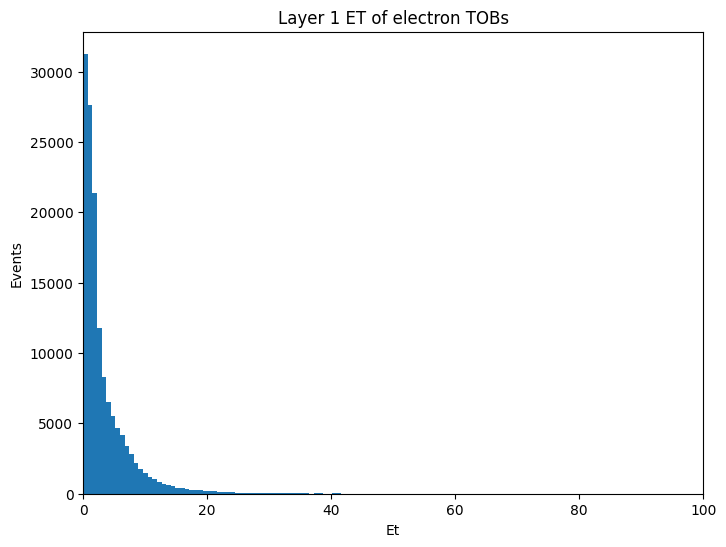

In [11]:
ax = DFs[0]["eFEX_L1_ET"].plot(kind='hist',bins=300, figsize=(8, 6))

ax.set_xlim(0, 100)
plt.title('Layer 1 ET of electron TOBs')
plt.xlabel('Et') # Change the label here
plt.ylabel('Events')

# Show the plot
plt.show()

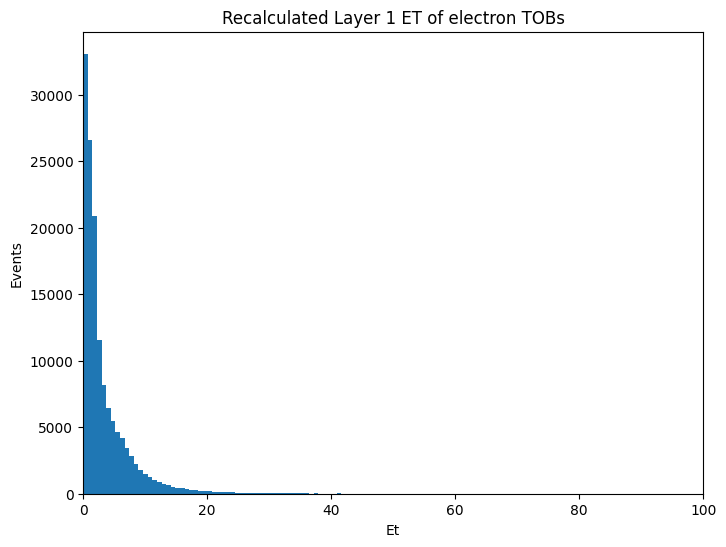

In [12]:
ax = DFs[0]["EM1_Clus"].plot(kind='hist',bins=300, figsize=(8, 6))

ax.set_xlim(0, 100)
plt.title('Recalculated Layer 1 ET of electron TOBs')
plt.xlabel('Et') # Change the label here
plt.ylabel('Events')

# Show the plot
plt.show()

In [13]:
DFs[1]['ID'].describe()

count    141741.000000
mean          0.407885
std           1.009922
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           3.000000
Name: ID, dtype: float64

<Axes: >

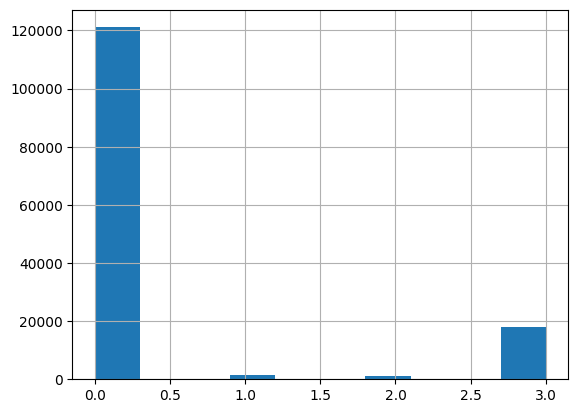

In [14]:
DFs[1]['ID'].hist()

In [15]:
# Discriminant using current eFEX isolation variables
DFs[0] = pd.concat([DFs[0][["eFEX_ReC", "eFEX_ReE", "eFEX_RhE" ,"eFEX_RhH" ,"eFEX_WsN", "eFEX_WsD"]], DFs[1]['ID'].copy()], axis=1)  # merge vars and decision 
DFs[2] = pd.concat([DFs[2][["eFEX_ReC", "eFEX_ReE", "eFEX_RhE" ,"eFEX_RhH" ,"eFEX_WsN", "eFEX_WsD"]], DFs[3]['ID'].copy()], axis=1)


In [16]:
DFs[0]['Label'] = 0  # apply labels
DFs[2]['Label'] = 1

#print (DFs[0],DFs[0].shape)
#print (DFs[2],DFs[2].shape)

In [17]:
DF = pd.concat([DFs[0], DFs[2]])  # merge electron and jet tobs

In [18]:
X = DF[["eFEX_ReC", "eFEX_ReE", "eFEX_RhE" ,"eFEX_RhH" ,"eFEX_WsN","eFEX_WsD"]]  # training variables
y = DF['Label']  # training labels

## Distribution of variables


In [19]:
X.describe()

,eFEX_ReC,eFEX_ReE,eFEX_RhE,eFEX_RhH,eFEX_WsN,eFEX_WsD
count,230910.000000,230910.000000,230910.000000,230910.000000,230910.000000,230910.000000
mean,13.343319,1.877509,20.838499,3.142241,3.021421,6.137535
std,12.271285,4.669007,17.522993,9.805500,5.369278,5.260538
min,0.400000,0.000000,1.775000,0.000000,0.000000,0.000000
25%,3.250000,0.000000,5.175000,0.000000,0.000000,1.725000
50%,11.575000,0.000000,19.475000,0.000000,1.175000,5.475000
75%,20.350000,1.500000,32.075001,1.500000,3.325000,9.375000
max,402.799988,225.675003,661.700012,342.000000,204.375000,226.100006


In [20]:
DFs[1].columns         # background

Index(['TOB_ET', 'TOB_eta', 'TOB_ieta', 'TOB_ietabin', 'TOB_phi',
       'offline_ele_pt', 'offline_ele_eta', 'offline_ele_eta_cal',
       'offline_ele_phi', 'offline_ele_phi_cal', 'eFEX_ET', 'eFEX_PS_ET',
       'eFEX_L1_ET', 'eFEX_L2_ET', 'eFEX_L3_ET', 'SuperCell_ET', 'ID'],
      dtype='object')

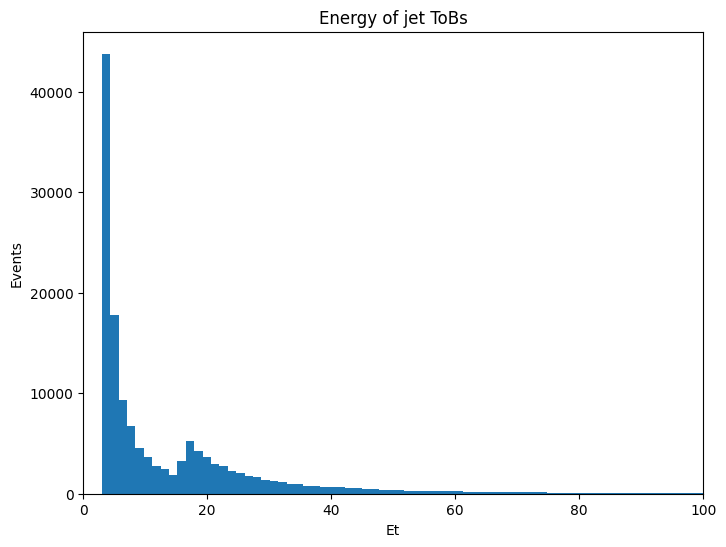

In [21]:
ax = DFs[1]["TOB_ET"].plot(kind='hist',bins=300, figsize=(8, 6))

ax.set_xlim(0, 100)
plt.title('Energy of jet ToBs')
plt.xlabel('Et') # Change the label here
plt.ylabel('Events')

# Show the plot
plt.show()

In [22]:
DFs[3].columns         # signal

Index(['TOB_ET', 'TOB_eta', 'TOB_ieta', 'TOB_ietabin', 'TOB_phi',
       'offline_ele_pt', 'offline_ele_eta', 'offline_ele_eta_cal',
       'offline_ele_phi', 'offline_ele_phi_cal', 'eFEX_ET', 'eFEX_PS_ET',
       'eFEX_L1_ET', 'eFEX_L2_ET', 'eFEX_L3_ET', 'SuperCell_ET', 'ID'],
      dtype='object')

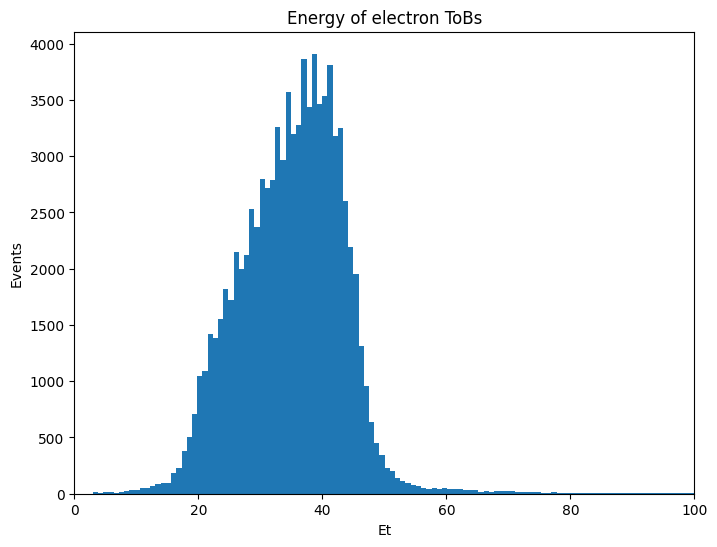

In [23]:
ax = DFs[3]["TOB_ET"].plot(kind='hist',bins=300, figsize=(8, 6))

ax.set_xlim(0, 100)
plt.title('Energy of electron ToBs')
plt.xlabel('Et') # Change the label here
plt.ylabel('Events')

# Show the plot
plt.show()